# FloPy

### Zonbud Example 1

This notebook demonstrates how to use the functions included in the zonbud utility to extract budget information from the cell by cell budget file using an array of zones.

First set the path and import the required packages. The flopy path doesn't have to be set if you install flopy from a binary installer. If you want to run this notebook, you have to set the path to your own flopy path.

In [1]:
%matplotlib inline
from __future__ import print_function
import os
import platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from flopy.utils import ZoneBudget

# Set path to example datafiles
zbudpath = os.path.join('..', 'data', 'zonbud_examples')

### Create a ZoneBudget Object and Make Some Zones

We create a simple numpy integer-array to define some zones for which we are interested in getting cell-by-cell budget information.

In [2]:
# Create ZoneBudget object
cbc_file = os.path.join(zbudpath, 'freyberg.gitcbc')
zb = ZoneBudget(cbc_file)

print(zb.ssst_record_names)
print(zb.get_kstpkper())
print(zb.get_model_shape())

[u'WELLS', u'RIVER LEAKAGE', u'RECHARGE']
[(0, 0)]
(1L, 40L, 20L)


[1 2 3 4]


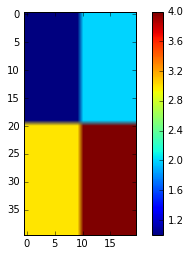

In [3]:
# Define some very interesting zones
nlay, nrow, ncol = zb.get_model_shape()
zon = np.zeros((nlay, nrow, ncol), np.int32)
zon[0, :20, :10] = 1
zon[0, :20, 10:] = 2
zon[0, 20:, :10] = 3
zon[0, 20:, 10:] = 4

im = plt.imshow(zon[0, :, :], )
cbar = plt.colorbar(im)
print(np.unique(zon))

### Extract Budget Information from ZoneBudget Object

We use the `get_budget()` method of the ZoneBudget object to return a Budget object, which is a thin wrapper around a numpy record array.

In [4]:
bud = zb.get_budget(zon, kstpkper=(0, 0))

In [5]:
# Get the budget record array
records = bud.get_records()
print(records.dtype)
print(records)

[('flow_dir', 'S3'), ('record', 'S20'), ('ZONE 1', '<f8'), ('ZONE 2', '<f8'), ('ZONE 3', '<f8'), ('ZONE 4', '<f8')]
[('IN', 'CONSTANT HEAD', 0.0, 0.0, 0.0, 0.0)
 ('IN', 'WELLS', 0.0, 0.0, 0.0, 0.0)
 ('IN', 'RIVER LEAKAGE', 0.0, 0.004194190260022879, 0.0, 0.0)
 ('IN', 'RECHARGE', 0.015300000726711005, 0.020000000949949026, 0.015900000755209476, 0.01830000086920336)
 ('IN', 'FROM ZONE 1', 0.0, 0.013101870426908135, 0.0028348490013740957, 0.0)
 ('IN', 'FROM ZONE 2', 0.0, 0.0, 0.0, 0.001225714382599108)
 ('IN', 'FROM ZONE 3', 0.0006367169262375683, 0.0, 0.0, 0.013000612932955846)
 ('IN', 'FROM ZONE 4', 0.0, 0.001146163951489143, 0.0, 0.0)
 ('OUT', 'CONSTANT HEAD', 0.0, 0.0, 0.0035475197073537856, 0.0011877618562721182)
 ('OUT', 'WELLS', 0.0, 0.01619999995455146, 0.0015499999863095582, 0.00430000014603138)
 ('OUT', 'RIVER LEAKAGE', 0.0, 0.02101684292574646, 0.0, 0.025892717123497277)
 ('OUT', 'RECHARGE', 0.0, 0.0, 0.0, 0.0)
 ('OUT', 'TO ZONE 1', 0.0, 0.0, 0.0006367169262375683, 0.0)
 ('OUT'

In [6]:
# Pass a list of (flow_dir, record name) tuples and/or zones to get a subset of the entire budget
recordlist = [('IN', 'RECHARGE'), ('IN', 'FROM ZONE 1'), ('IN', 'FROM ZONE 3')]
records = bud.get_records(recordlist=recordlist, zones=[1, 3])
print(records.dtype)
print(records)

[('flow_dir', 'S3'), ('record', 'S20'), ('ZONE 1', '<f8'), ('ZONE 3', '<f8')]
[[('IN', 'RECHARGE', 0.015300000726711005, 0.015900000755209476)]
 [('IN', 'FROM ZONE 1', 0.0, 0.0028348490013740957)]
 [('IN', 'FROM ZONE 3', 0.0006367169262375683, 0.0)]]


In [7]:
# View the budget as a Pandas DataFrame
records = bud.get_records()
df = pd.DataFrame(records)
df = df.set_index(['flow_dir', 'record']).sort_index()  # sort multi-index so we can slice it later
df

ZONE 1    ZONE 2    ZONE 3    ZONE 4
flow_dir record                                               
IN       CONSTANT HEAD  0.000000  0.000000  0.000000  0.000000
         FROM ZONE 1    0.000000  0.013102  0.002835  0.000000
         FROM ZONE 2    0.000000  0.000000  0.000000  0.001226
         FROM ZONE 3    0.000637  0.000000  0.000000  0.013001
         FROM ZONE 4    0.000000  0.001146  0.000000  0.000000
         RECHARGE       0.015300  0.020000  0.015900  0.018300
         RIVER LEAKAGE  0.000000  0.004194  0.000000  0.000000
         WELLS          0.000000  0.000000  0.000000  0.000000
OUT      CONSTANT HEAD  0.000000  0.000000  0.003548  0.001188
         RECHARGE       0.000000  0.000000  0.000000  0.000000
         RIVER LEAKAGE  0.000000  0.021017  0.000000  0.025893
         TO ZONE 1      0.000000  0.000000  0.000637  0.000000
         TO ZONE 2      0.013102  0.000000  0.000000  0.001146
         TO ZONE 3      0.002835  0.000000  0.000000  0.000000
         TO ZONE 4      0.000000  0.001226  0.013001  0.000000
         WELLS          0.000000  0.016200  0.001550  0.004300

In [8]:
# Look at recharge in zones 3 and 4
df.loc[(['IN'], ['RECHARGE']), ['ZONE 3', 'ZONE 4']].sum(axis=1)  # axis=1 to sum along rows

flow_dir  record  
IN        RECHARGE    0.0342
dtype: float64

In [9]:
# Look at all outflow from zone 1
df.loc[(['OUT'], slice(None)), 'ZONE 1'].sum()

0.015936719428282231

In [10]:
# Look at flow to zone 2
df.loc[(slice(None), ['TO ZONE 2']), :].sum(axis=1)  # axis=1 to sum along rows

flow_dir  record   
OUT       TO ZONE 2    0.014248
dtype: float64

We can use the Budget object to look at the mass-balance:

In [11]:
# Look at all of the mass-balance records
print(bud.get_mass_balance())

# Look at the mass-balance for just zones 1 and 3
print(bud.get_mass_balance(zones=[1, 3]))

[ ('INFLOW', 0.015936717652948573, 0.03844222558836918, 0.01873484975658357, 0.03252632818475831)
 ('OUTFLOW', 0.01593671942828223, 0.038442557262897026, 0.018734849552856758, 0.03252664307728992)
 ('ERROR', -1.1139894661101299e-05, -0.0008627832856969281, 1.0874216604444852e-06, -0.0009681111423396122)]
[('INFLOW', 0.015936717652948573, 0.01873484975658357)
 ('OUTFLOW', 0.01593671942828223, 0.018734849552856758)
 ('ERROR', -1.1139894661101299e-05, 1.0874216604444852e-06)]


In [12]:
# Look at just the percent error record
print(bud.get_percent_error())

# Look at the total inflow for zones 1 and 3
print(bud.get_total_inflow(zones=[1, 3]))

[ -1.11398947e-05  -8.62783286e-04   1.08742166e-06  -9.68111142e-04]
[ 0.01593672  0.01873485]


In [13]:
# View the mass-balance as a Pandas DataFrame
mb = bud.get_mass_balance()
mb = pd.DataFrame(mb).set_index(['record'])
mb

,ZONE 1,ZONE 2,ZONE 3,ZONE 4
record,,,,
INFLOW,0.015937,0.038442,0.018735,0.032526
OUTFLOW,0.015937,0.038443,0.018735,0.032527
ERROR,-0.000011,-0.000863,0.000001,-0.000968


In [14]:
mb.loc['INFLOW'][['ZONE 1', 'ZONE 3']]

ZONE 1    0.015937
ZONE 3    0.018735
Name: INFLOW, dtype: float64

### Write Budget Output to CSV

We can write the resulting recarray to a csv with the .to_csv() method of the Budget object.

In [15]:
bud.to_csv(os.path.join(zbudpath, 'zbud.csv'), write_format='zonbud')
bud.to_csv(os.path.join(zbudpath, 'zbud_pandas.csv'), write_format='pandas')

In [16]:
# Read the file in to see the contents
try:
    import pandas as pd
    df = pd.read_csv(os.path.join(zbudpath, 'zbud_pandas.csv'))
    df = df.fillna(0)
    print(df.to_string(index=False))
except:
    with open(out_fname, 'r') as f:
        for line in f.readlines():
            print('\t'.join(line.split(',')))

flow_dir         record        ZONE 1        ZONE 2        ZONE 3        ZONE 4
     IN  CONSTANT HEAD  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
     IN          WELLS  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
     IN  RIVER LEAKAGE  0.000000e+00  4.194190e-03  0.000000e+00  0.000000e+00
     IN       RECHARGE  1.530000e-02  2.000000e-02  1.590000e-02  1.830000e-02
     IN    FROM ZONE 1  0.000000e+00  1.310187e-02  2.834849e-03  0.000000e+00
     IN    FROM ZONE 2  0.000000e+00  0.000000e+00  0.000000e+00  1.225714e-03
     IN    FROM ZONE 3  6.367169e-04  0.000000e+00  0.000000e+00  1.300061e-02
     IN    FROM ZONE 4  0.000000e+00  1.146164e-03  0.000000e+00  0.000000e+00
              Total IN  1.593672e-02  3.844223e-02  1.873485e-02  3.252633e-02
    OUT  CONSTANT HEAD  0.000000e+00  0.000000e+00  3.547520e-03  1.187762e-03
    OUT          WELLS  0.000000e+00  1.620000e-02  1.550000e-03  4.300000e-03
    OUT  RIVER LEAKAGE  0.000000e+00  2.101684e-02 